In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import logging
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import foolbox
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from lib.dataset_utils import *
from lib.mnist_model import *
from lib.adv_model import *
from lib.dknn_attack_v2 import DKNNAttackV2
from lib.cwl2_attack import CWL2Attack
from lib.dknn import DKNNL2
from lib.utils import *
from lib.lip_model import *

Loading faiss with AVX2 support.


In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
# Set all random seeds
seed = 2020
np.random.seed(seed)
torch.manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = load_mnist_all(
    '/data', val_size=0.1, shuffle=True, seed=seed)

In [6]:
# model_name = 'mnist_basic.h5'
# net = BasicModel()

# model_name = 'train_mnist_nca_exp2.h5'
# model_name = 'adv_mnist_nca_exp63_epoch119.h5'
# model_name = 'adv_mnist_nca_exp80.h5'
# # net = NCAModel(output_dim=100, init_it=1, train_data=(x_train, y_train))
# net = NCAModelV3(normalize=False, output_dim=20, init_it=1, 
#                  train_data=(x_train, y_train))

# model_name = 'train_mnist_snnl_exp%d.h5' % exp_id
# net = SNNLModel(train_it=True)

# model_name = 'train_mnist_hidden_mixup_exp%d.h5' % exp_id
# net = HiddenMixupModel()

# model_name = 'train_mnist_vae_exp%d.h5' % exp_id
# # net = VAE((1, 28, 28), num_classes=10, latent_dim=20)
# net = VAE2((1, 28, 28), num_classes=10, latent_dim=128)

# model_name = 'train_mnist_cav_exp%d.h5' % exp_id
# net = ClassAuxVAE((1, 28, 28), num_classes=10, latent_dim=20)

# model_name = 'lip_mnist_exp%d.h5' % exp_id
# net = LipschitzModel()

# model_name = 'dist_mnist_exp%d.h5' % exp_id
# init_it = 1
# train_it = False
# net = NeighborModel(num_classes=10, init_it=init_it, train_it=train_it)

# model_name = 'mnist_at.h5'
model_name = 'adv_mnist_exp6.h5'
basic_net = BasicModel()
# basic_net = BasicModelV2()
config = {'epsilon': 0.3,
          'num_steps': 40,
          'step_size': 0.01,
          'random_start': True,
          'loss_func': 'xent'}
net = PGDL2Model(basic_net, config)

# model_name = 'lipae_mnist_exp%d.h5' % exp_id
# init_it = 1
# train_it = False
# latent_dim = 128
# alpha = 1e2
# net = NCA_AE(latent_dim=latent_dim, init_it=init_it,
#              train_it=train_it, alpha=alpha)

# orig_model = 'adv_mnist_exp2.h5'
# model_name = 'tune%d_%s' % (exp_id, orig_model)
# net = BasicModel()
# from tune_mnist import Identity
# net.fc = Identity()

# model_name = 'rot_mnist_exp%d.h5' % exp_id
# net = BasicModel(num_classes=4)

# model_name = 'adv_rot_mnist_exp%d.h5' % exp_id
# basic_net = BasicModel(num_classes=4)
# config = {'num_steps': 20,
#           'step_size': 0.05,
#           'random_start': True,
#           'loss_func': 'xent'}
# net = PGDL2Model(basic_net, config)

# model_name = 'ae_mnist_exp%d.h5' % exp_id
# net = Autoencoder((1, 28, 28), 128)

# model_name = 'adv_mnist_ae_exp%d.h5' % exp_id
# basic_net = Autoencoder((1, 28, 28), latent_dim=128)
# config = {'num_steps': 40,
#               'step_size': 0.1,
#               'random_start': True,
#               'loss_func': 'xent'}
# net = PGDL2Model(basic_net, config)

In [8]:
# Set up model directory
# save_dir = os.path.join(os.getcwd(), 'saved_models/mnist/')
save_dir = os.path.join(os.getcwd(), 'saved_models/')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

net = net.to(device)
# if device == 'cuda':
#     net = torch.nn.DataParallel(net)
#     cudnn.benchmark = True
net.load_state_dict(torch.load(model_path))
# net = net.module
net = net.basic_net
net.eval()

BasicModel(
  (conv1): Conv2d(1, 64, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2), padding=(3, 3))
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU(inplace=True)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)

In [9]:
layers = ['relu1', 'relu2', 'relu3', 'fc']
# layers = ['relu3']
# layers = ['fc']
# layers = ['conv3']
# layers = ['en_mu']
# layers = ['maxpool1', 'maxpool2', 'relu3', 'fc2']
# layers = ['maxpool2']

# dknn = DKNN(net, x_train, y_train, x_valid, y_valid, layers, 
#             k=75, num_classes=10)
dknn = DKNNL2(net, x_train, y_train, x_valid, y_valid, layers, 
              k=75, cosine=True, num_classes=10)

In [31]:
net_knn = KNNModel()
layers = ['identity']
dknn = DKNNL2(net_knn, x_train, y_train, 
              x_test, y_test, layers, 
              k=5, num_classes=10)

In [10]:
with torch.no_grad():
    y_pred = dknn.classify(x_test)
    ind = np.where(y_pred.argmax(1) == y_test.numpy())[0]
    print((y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0))

0.9773


In [11]:
def attack_batch(attack, x, y, init_mode, init_mode_k, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            x[begin:end], y[begin:end], 2, guide_layer=layers, m=150,
            init_mode=init_mode, init_mode_k=init_mode_k,
            binary_search_steps=10, max_iterations=1000, learning_rate=1e-1,
            initial_const=1e0, max_linf=None, random_start=True,
            thres_steps=200, check_adv_steps=200, verbose=False)
    return x_adv

num = 100

def full_eval(dknn):
    with torch.no_grad():
        y_pred = dknn.classify(x_test)
        ind = np.where(y_pred.argmax(1) == y_test.numpy())[0]
    print((y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0))
    
    dist_all = np.zeros(num) + 1e9
    x_adv_all = x_test[ind][:num].clone()
    attack = DKNNAttackV2(dknn)
    
    x_adv = attack_batch(
        attack, x_test[ind][:num].cuda(), y_test[ind][:num], 1, 1, 100)
    with torch.no_grad():
        y_pred = dknn.classify(x_adv)
        ind_adv = y_pred.argmax(1) != y_test[ind][:num].numpy()
        dist = (x_adv.cpu() - x_test[ind][:num]).view(
            num, -1).norm(2, 1).numpy()
    for i in range(num):
        if ind_adv[i] and (dist[i] < dist_all[i]):
            dist_all[i] = dist[i]
            x_adv_all[i] = x_adv[i]
            
    for k in range(1, 3):
        x_adv = attack_batch(
            attack, x_test[ind][:num].cuda(), y_test[ind][:num], 2, k, 100)
        with torch.no_grad():
            y_pred = dknn.classify(x_adv)
            ind_adv = y_pred.argmax(1) != y_test[ind][:num].numpy()
            dist = (x_adv.cpu() - x_test[ind][:num]).view(
                num, -1).norm(2, 1).numpy()
        for i in range(num):
            if ind_adv[i] and (dist[i] < dist_all[i]):
                dist_all[i] = dist[i]
                x_adv_all[i] = x_adv[i]
                
    adv_acc = (dist_all == 1e9).mean()
    print('adv accuracy: %.4f, mean dist: %.4f' % (
        adv_acc, dist_all[dist_all < 1e9].mean()))
    return dist_all, x_adv_all

In [12]:
start = time.time()
dist, x_adv = full_eval(dknn)
print(time.time() - start)

0.9773
    step: 0; loss: 76.239; dist: 0.032
    step: 100; loss: 24.533; dist: 3.274
    step: 200; loss: 18.099; dist: 3.281
    step: 300; loss: 16.804; dist: 3.344
    step: 400; loss: 17.321; dist: 3.350
    step: 500; loss: 17.016; dist: 3.404
    step: 600; loss: 17.301; dist: 3.394
    step: 700; loss: 17.162; dist: 3.424
    step: 800; loss: 17.482; dist: 3.430
    step: 900; loss: 17.423; dist: 3.464
binary step: 0; num successful adv: 100/100
binary step: 0; num successful adv so far: 100/100
    step: 0; loss: 7.297; dist: 0.032
    step: 100; loss: 6.518; dist: 0.916
    step: 200; loss: 6.443; dist: 0.939
    step: 300; loss: 6.423; dist: 0.998
    step: 400; loss: 6.426; dist: 1.000
    step: 500; loss: 6.423; dist: 1.020
    step: 600; loss: 6.431; dist: 1.022
    step: 700; loss: 6.428; dist: 1.026
    step: 800; loss: 6.428; dist: 1.026
    step: 900; loss: 6.427; dist: 1.032
binary step: 1; num successful adv: 5/100
binary step: 1; num successful adv so far: 100/100

In [12]:
dist.mean()

3.4499070656299593

In [15]:
# Attack for L2 DkNN
from lib.dknn_attack_l2_v1 import DKNNL2AttackV1
attack = DKNNL2AttackV1()

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            dknn, x[begin:end], y[begin:end],
            guide_layer=layers[0], m=100, binary_search_steps=10,
            max_iterations=1000, learning_rate=1e-1, guide_mode=1,
            initial_const=1e1, abort_early=True, random_start=True)
    return x_adv

num = 100
x_adv = attack_batch(x_test[ind][:num].cuda(), y_test[ind][:num], 100)

    step: 0; loss: 559.819; l2dist: 0.032
    step: 100; loss: 513.798; l2dist: 3.763
    step: 200; loss: 513.769; l2dist: 3.772
binary step: 0; num successful adv: 98/100
binary step: 0; num successful adv so far: 98/100
    step: 0; loss: 388.695; l2dist: 0.032
    step: 100; loss: 364.403; l2dist: 3.097
    step: 200; loss: 364.281; l2dist: 3.103
    step: 300; loss: 364.280; l2dist: 3.105
binary step: 1; num successful adv: 75/100
binary step: 1; num successful adv so far: 100/100
    step: 0; loss: 272.103; l2dist: 0.032
    step: 100; loss: 257.084; l2dist: 2.607
    step: 200; loss: 257.064; l2dist: 2.608
binary step: 2; num successful adv: 47/100
binary step: 2; num successful adv so far: 100/100
    step: 0; loss: 252.374; l2dist: 0.032
    step: 100; loss: 238.729; l2dist: 2.574
    step: 200; loss: 238.709; l2dist: 2.581
binary step: 3; num successful adv: 48/100
binary step: 3; num successful adv so far: 100/100
    step: 0; loss: 241.471; l2dist: 0.032
    step: 100; loss

In [16]:
with torch.no_grad():
    y_pred = dknn.classify(x_adv)
    ind_adv = np.where(y_pred.argmax(1) != y_test[ind][:num].numpy())[0]
    dist = (x_adv.cpu() - x_test[ind][:num]).view(num, -1).norm(2, 1)
    print('mean dist: ', dist[ind_adv].mean().item())
    print('success rate: ', (len(ind_adv) / num))

mean dist:  2.679206609725952
success rate:  1.0


In [26]:
attack = DKNNAttackV2(dknn)
num = 100
x_adv = attack_batch(
    attack, x_test[ind][:num].cuda(), y_test[ind][:num], 1, 1, 100)

In [28]:
with torch.no_grad():
    y_pred = dknn.classify(x_adv)
    ind_adv = np.where(y_pred.argmax(1) != y_test[ind][:num].numpy())[0]
    adv_acc = (y_pred.argmax(1) == y_test[ind][:num].numpy()).sum() \
        / y_pred.shape[0]
    dist = (x_adv.cpu() - x_test[ind][:num]).view(
        num, -1).norm(2, 1)[ind_adv].mean()
print('adv accuracy: %.4f, mean dist: %.4f' % (adv_acc, dist.item()))

adv accuracy: 0.0000, mean dist: 2.6240


---

In [10]:
net.recompute_train_rep()

In [11]:
train_len = len(x_train)
train_rep = net.get_train_rep(requires_grad=False)
y_pred = torch.zeros((train_len, 10))
mask = []
for i in range(10):
    mask.append((y_train == i).float().cuda())
for i in range(train_len):
    dist = ((train_rep[i].unsqueeze(0) - train_rep) ** 2).sum(1)
    exp = torch.clamp(- dist * net.log_it.exp(), - 50, 50).exp()
    exp[i] = 0
    exp_sum = exp.sum()
    for j in range(net.num_classes):
        y_pred[i, j] = (mask[j] * exp).sum() / exp_sum

In [12]:
ind_train = np.where((y_pred.argmax(1) == y_train).numpy())[0]

In [54]:
layers = ['fc']
dknn = DKNNL2(net, x_train[ind_train], y_train[ind_train], 
              x_valid, y_valid, layers, k=50, num_classes=10)

In [55]:
with torch.no_grad():
    y_pred = dknn.classify(x_test)
    ind = np.where(y_pred.argmax(1) == y_test.numpy())[0]
    print((y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0))

0.9738


---

In [124]:
ind_train = np.arange(len(x_train))
np.random.shuffle(ind_train)
ind_train = ind_train[:500]

In [13]:
net.train_data = (x_train[ind_train], y_train[ind_train])
# net.train_data = (x_train, y_train)

In [14]:
net.recompute_train_rep()

with torch.no_grad():
    batch_size = 200
    num_batches = int(np.ceil(len(x_test) / batch_size))
    logits = np.zeros((len(x_test), 10))
    for i in range(num_batches):
        logits[i * batch_size:(i + 1) * batch_size] = net.compute_logits(
            x_test[i * batch_size:(i + 1) * batch_size].cuda()).cpu().numpy()

In [15]:
ind = logits.argmax(1) == y_test.numpy()
ind = np.where(ind)[0]
print(len(ind) / len(x_test))

0.9612


In [16]:
from lib.cwl2_attack import CWL2AttackNCA
attack = CWL2AttackNCA(net)
num = 100

In [17]:
x_adv = attack(x_test[ind][:num].cuda(), y_test[ind][:num].cuda(), 
               targeted=False, init_mode=2,
               binary_search_steps=10, max_iterations=1000, confidence=0,
               learning_rate=1e-1, initial_const=1, abort_early=True,
               rand_start_std=0.1, check_adv_steps=200)

    step: 0; loss: 0.639; l2dist: 0.000
    step: 100; loss: 0.652; l2dist: 0.126
binary step: 0; number of successful adv: 0/100
    step: 0; loss: 6.496; l2dist: 0.322
    step: 100; loss: 5.939; l2dist: 0.497
    step: 200; loss: 5.930; l2dist: 0.511
    step: 300; loss: 5.933; l2dist: 0.511
binary step: 1; number of successful adv: 12/100
    step: 0; loss: 57.690; l2dist: 0.322
    step: 100; loss: 16.561; l2dist: 2.690
    step: 200; loss: 16.197; l2dist: 2.659
    step: 300; loss: 16.097; l2dist: 2.654
    step: 400; loss: 16.039; l2dist: 2.644
    step: 500; loss: 15.999; l2dist: 2.644
    step: 600; loss: 16.058; l2dist: 2.653
binary step: 2; number of successful adv: 77/100
    step: 0; loss: 174.042; l2dist: 0.321
    step: 100; loss: 22.512; l2dist: 3.363
    step: 200; loss: 22.267; l2dist: 3.411
    step: 300; loss: 21.797; l2dist: 3.366
    step: 400; loss: 18.350; l2dist: 3.205
    step: 500; loss: 18.269; l2dist: 3.169
    step: 600; loss: 18.225; l2dist: 3.142
    ste

In [ ]:
x_adv = attack(x_test[:num].cuda(), y_test[:num].cuda(), 
               targeted=False, init_mode=2,
               binary_search_steps=10, max_iterations=1000, confidence=0,
               learning_rate=1e-1, initial_const=1, abort_early=True,
               rand_start_std=0.1, check_adv_steps=200)

In [18]:
(x_adv.cpu() - x_test[ind][:num]).view(num, -1).norm(2, 1).mean()

tensor(2.7946, grad_fn=<MeanBackward0>)

In [34]:
(x_adv.cpu() - x_test[:num]).view(num, -1).norm(2, 1).mean()

tensor(2.6804, grad_fn=<MeanBackward0>)

In [126]:
net.recompute_train_rep()

with torch.no_grad():
    out = net.compute_logits(x_adv).cpu().argmax(1)
    print((out == y_test[ind][:num]).numpy().mean())

0.12


In [148]:
accs = []
size = [200, 500, 1000, 5000, 10000]
for n in size:
    acc = []
    for i in range(100):
        ind_train = np.arange(len(x_train))
        np.random.shuffle(ind_train)
        ind_train = ind_train[:n]
        net.train_data = (x_train[ind_train], y_train[ind_train])

        net.recompute_train_rep()

        with torch.no_grad():
            out = net.compute_logits(x_adv).cpu().argmax(1)
            acc.append((out == y_test[ind][:num]).numpy().mean())
    accs.append(acc)

In [149]:
accs = np.array(accs)

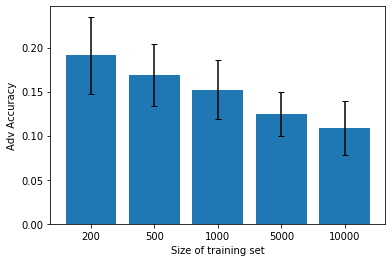

In [166]:
plt.bar(np.arange(len(size)), accs.mean(1), yerr=accs.std(1),
        align='center', capsize=3)
plt.xticks(np.arange(len(size)), size)
plt.ylabel('Adv Accuracy')
plt.xlabel('Size of training set')
plt.show()

In [14]:
model_name = 'adv_mnist_exp6.h5'
basic_net = BasicModel()
# # basic_net = BasicModelV2()
config = {'epsilon': 3,
          'num_steps': 40,
          'step_size': 0.2,
          'random_start': True,
          'loss_func': 'xent'}
net = PGDL2Model(basic_net, config)

In [15]:
# Set up model directory
# save_dir = os.path.join(os.getcwd(), 'saved_models/mnist/')
save_dir = os.path.join(os.getcwd(), 'saved_models/')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

net = net.to(device)
# if device == 'cuda':
#     net = torch.nn.DataParallel(net)
#     cudnn.benchmark = True
net.load_state_dict(torch.load(model_path))
# net = net.module
net = net.basic_net
net.eval()

BasicModel(
  (conv1): Conv2d(1, 64, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2), padding=(3, 3))
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU(inplace=True)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)

In [16]:
with torch.no_grad():
    y_pred = net(x_test.to(device))
    ind = np.where(y_pred.argmax(1).cpu() == y_test)[0]
    print('acc: ', len(ind) / y_test.size(0))

acc:  0.9647


In [17]:
attack = CWL2Attack(net, x_train, y_train)

In [18]:
num = 100
x_adv = attack(x_test[:num].cuda(), y_test[:num].cuda(), 
               targeted=False, init_mode=2,
               binary_search_steps=10, max_iterations=1000, confidence=0,
               learning_rate=1e-1, initial_const=1, abort_early=True,
               rand_start_std=0.1, check_adv_steps=20)

    step: 0; loss: 2.410; l2dist: 0.000
    step: 100; loss: 2.330; l2dist: 0.304
    step: 200; loss: 2.330; l2dist: 0.315
binary step: 0; number of successful adv: 2/97
    step: 0; loss: 23.933; l2dist: 0.317
    step: 100; loss: 10.869; l2dist: 2.284
    step: 200; loss: 10.364; l2dist: 2.348
    step: 300; loss: 10.229; l2dist: 2.355
    step: 400; loss: 10.227; l2dist: 2.360
    step: 500; loss: 10.204; l2dist: 2.386
    step: 600; loss: 10.197; l2dist: 2.373
    step: 700; loss: 10.201; l2dist: 2.372
binary step: 1; number of successful adv: 42/97
    step: 0; loss: 164.953; l2dist: 0.316
    step: 100; loss: 13.769; l2dist: 3.365
    step: 200; loss: 12.301; l2dist: 3.208
    step: 300; loss: 12.478; l2dist: 3.257
binary step: 2; number of successful adv: 97/97
    step: 0; loss: 176.101; l2dist: 0.323
    step: 100; loss: 12.643; l2dist: 3.226
    step: 200; loss: 12.079; l2dist: 3.222
    step: 300; loss: 11.492; l2dist: 3.137
    step: 400; loss: 11.255; l2dist: 3.062
    st

In [23]:
(x_adv.cpu() - x_test[:num]).view(num, -1).norm(2, 1).mean()

tensor(2.7354, grad_fn=<MeanBackward0>)

In [12]:
num = 100
x_adv = attack(x_test[ind][:num].cuda(), y_test[ind][:num].cuda(), 
               targeted=False, init_mode=2,
               binary_search_steps=10, max_iterations=1000, confidence=0,
               learning_rate=1e-1, initial_const=1, abort_early=True,
               rand_start_std=0.1, check_adv_steps=20)

    step: 0; loss: 2.462; l2dist: 0.000
    step: 100; loss: 2.375; l2dist: 0.311
    step: 200; loss: 2.377; l2dist: 0.321
binary step: 0; number of successful adv: 2/100
    step: 0; loss: 24.473; l2dist: 0.321
    step: 100; loss: 10.958; l2dist: 2.296
    step: 200; loss: 10.463; l2dist: 2.341
    step: 300; loss: 10.334; l2dist: 2.362
    step: 400; loss: 10.347; l2dist: 2.375
binary step: 1; number of successful adv: 40/100
    step: 0; loss: 149.058; l2dist: 0.329
    step: 100; loss: 13.512; l2dist: 3.336
    step: 200; loss: 13.318; l2dist: 3.351
    step: 300; loss: 12.657; l2dist: 3.267
    step: 400; loss: 11.570; l2dist: 3.119
    step: 500; loss: 11.755; l2dist: 3.188
binary step: 2; number of successful adv: 100/100
    step: 0; loss: 85.186; l2dist: 0.321
    step: 100; loss: 13.728; l2dist: 3.402
    step: 200; loss: 11.941; l2dist: 3.173
    step: 300; loss: 12.185; l2dist: 3.235
binary step: 3; number of successful adv: 100/100
    step: 0; loss: 62.458; l2dist: 0.32

In [19]:
with torch.no_grad():
    y_pred = net(x_adv)
    adv_ind = np.where(y_pred.argmax(1).cpu() != y_test[ind][:num])[0]
    print('adv success rate: ', len(adv_ind) / y_pred.size(0))

adv success rate:  1.0


In [20]:
dist = (x_adv.cpu() - x_test[ind][:num])[adv_ind].view(len(adv_ind), -1)
print('mean dist: %.4f' % dist.norm(2, 1).mean())

mean dist: 2.8263


---

## SPL Weighting

In [7]:
model_name = 'adv_mnist_nca_exp64.h5'
model = WeightedNCA(normalize=False, output_dim=10, init_it=1, 
                    train_data=(x_train, y_train))

save_dir = os.path.join(os.getcwd(), 'saved_models/')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model = model.to(device)
model.load_state_dict(torch.load(model_path), strict=False)
model.eval()

WeightedNCA(
  (conv1): Conv2d(1, 64, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2), padding=(3, 3))
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU(inplace=True)
  (fc_): Linear(in_features=2048, out_features=10, bias=True)
  (fc): Sigmoid()
)

In [8]:
model.recompute_train_rep()

In [10]:
model.compute_logits(x_test[:2].cuda()).sigmoid()

tensor([[0.5022, 0.5080, 0.5068, 0.5075, 0.5341, 0.5053, 0.5011, 0.6253, 0.5044,
         0.5523],
        [0.5057, 0.5127, 0.6546, 0.5161, 0.5069, 0.5048, 0.5096, 0.5097, 0.5193,
         0.5054]], device='cuda:0')

In [13]:
trainloader, _, _ = load_mnist(
        100, data_dir='/data', val_size=0.1, shuffle=True, seed=seed)

In [ ]:
for batch_idx, (inputs, targets) in enumerate(trainloader):
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs, outputs_adv = net.compute_logits(self, x, recompute_train_rep=False, requires_grad=False,
                       from_outputs=False)
    loss = net.loss_function(outputs_adv, targets, orig=outputs)
    loss.backward()
    optimizer.step()

---
## Soft Label

In [11]:
ys_train = np.zeros((len(y_train), 10))
nb = dknn.get_neighbors(x_train, k=100)[0][1]
for i in range(len(y_train)):
    ys_train[i] = np.bincount(y_train[nb[i]], minlength=10) / 100

In [12]:
layers = ['fc']
dknn = DKNNL2(net, x_train, y_train, x_valid, y_valid, layers, 
              k=100, num_classes=10, ys_train=torch.tensor(ys_train))

In [15]:
net = SoftLabelNCA(torch.tensor(ys_train).cuda().float(), 
                   normalize=False, output_dim=20, 
                   init_it=1, train_data=(x_train, y_train))

save_dir = os.path.join(os.getcwd(), 'saved_models/')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
net = net.to(device)
net.load_state_dict(torch.load(model_path))
net.eval()

SoftLabelNCA(
  (conv1): Conv2d(1, 64, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2), padding=(3, 3))
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU(inplace=True)
  (fc_): Linear(in_features=2048, out_features=20, bias=True)
  (fc): Sigmoid()
)

In [16]:
net.recompute_train_rep()

In [2]:
ys_test = dknn.classify_soft(x_test)
(ys_test.argmax(1) == y_test.numpy()).mean()

NameError: name 'dknn' is not defined

In [56]:
out = dknn.classify(x_test)
cred = dknn.credibility(out)

(array([ 970.,  975.,  903.,  821.,  729.,    0.,    0.,    0.,    0.,
        5602.]),
 array([0.005 , 0.1045, 0.204 , 0.3035, 0.403 , 0.5025, 0.602 , 0.7015,
        0.801 , 0.9005, 1.    ]),
 <a list of 10 Patch objects>)

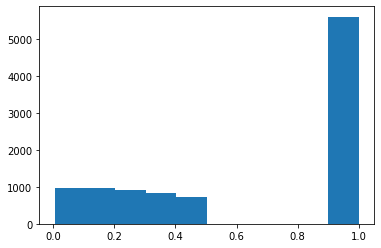

In [58]:
plt.hist(cred)

In [61]:
print(cred.mean(), np.median(cred))
print((cred < 0.5).mean())
train_cred = cred

0.6662565166666666 1.0
0.4398


In [11]:
out = dknn.classify(x_adv)
cred = dknn.credibility(out)

(array([70., 18.,  0.,  9.,  0.,  2.,  0.,  0.,  0.,  1.]),
 array([0.27566667, 0.29341667, 0.31116667, 0.32891667, 0.34666667,
        0.36441667, 0.38216667, 0.39991667, 0.41766667, 0.43541667,
        0.45316667]),
 <a list of 10 Patch objects>)

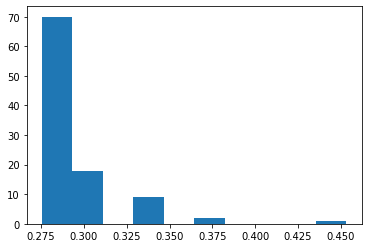

In [12]:
plt.hist(cred)

In [15]:
(dknn.A < 1).mean()

0.5468333333333333

In [27]:
dknn.classify(x_adv).argmax(1)

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6,
       6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2,
       3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4,
       6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3,
       6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9])

In [30]:
(y_test.numpy() == 1) & (y_test.numpy() == 1)

array([False, False,  True, ..., False, False, False])

In [13]:
pickle.dump(x_adv, open('x_adv_dknn_295.p', 'wb'))

In [18]:
(dknn.A < 5).mean()

0.7243333333333334

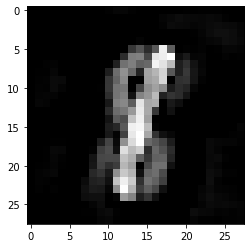

In [21]:
plt.imshow(x_adv[5].detach().cpu().numpy().reshape(28, 28), cmap='gray')